In [1]:
# Importando bibliotecas necessárias para a construção de grafos
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *
import pandas as pd
import numpy as np
import csv
import ast
import cpnet
from graph_tool import spectral
import seaborn as sns
import regression as reg
import cpnet

from scipy import stats
from matplotlib import pyplot as plt
from graph_tool import centrality
from graph_tool import spectral

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1582: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1583: PendingDeprecationWarning: The register_cmap function will b

In [2]:
df = pd.read_csv('./Video_Games_Sales_as_at_22_Dec_2016.csv')
df.dropna(subset=['Publisher'], inplace=True)
df_critic = df.loc[~df['Critic_Score'].isna()]
df_user = df.loc[~df['User_Score'].isna()]
df_rating = df.loc[~df['Rating'].isna()]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6943 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6943 non-null   object 
 1   Platform         6943 non-null   object 
 2   Year_of_Release  6825 non-null   float64
 3   Genre            6943 non-null   object 
 4   Publisher        6943 non-null   object 
 5   NA_Sales         6943 non-null   float64
 6   EU_Sales         6943 non-null   float64
 7   JP_Sales         6943 non-null   float64
 8   Other_Sales      6943 non-null   float64
 9   Global_Sales     6943 non-null   float64
 10  Critic_Score     6943 non-null   float64
 11  Critic_Count     6943 non-null   float64
 12  User_Score       6943 non-null   float64
 13  User_Count       6943 non-null   float64
 14  Developer        6943 non-null   object 
 15  Rating           6943 non-null   object 
dtypes: float64(10), object(6)
memory usage: 922.1+ KB


In [4]:
df.groupby('Genre')['Name'].count().sort_values(ascending=False)

Genre
Action          1663
Sports           965
Shooter          882
Role-Playing     718
Racing           591
Platform         406
Misc             394
Fighting         381
Simulation       301
Strategy         272
Adventure        249
Puzzle           121
Name: Name, dtype: int64

In [5]:
df_grouped_Genre = df.groupby(['Genre']).agg({'Global_Sales': np.mean})
df_grouped_Genre.sort_values('Global_Sales', ascending=False)

,Global_Sales
Genre,
Misc,1.077741
Shooter,0.934025
Platform,0.931429
Sports,0.881513
Racing,0.811844
Action,0.736091
Role-Playing,0.701100
Simulation,0.676146
Fighting,0.658110


In [6]:
sports_mean_sales = df_grouped_Genre.loc['Sports']['Global_Sales']
action_mean_sales = df_grouped_Genre.loc['Action']['Global_Sales'] 
rpg_mean_sales = df_grouped_Genre.loc['Role-Playing']['Global_Sales'] 

In [7]:
def segregate_genre_to_list(df, genre, df_list, threshold=None):
    seg_df = df[df['Genre'] == genre]
    if threshold:
        seg_df = seg_df[seg_df['Global_Sales'] > threshold]
    df_list.append(seg_df)

In [8]:
# sorted_years = df['Year_of_Release'].unique()
# sorted_years.sort()
sorted_years = list(range(1985, 2017))
print(sorted_years)

[1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


In [9]:
df_list = []

margem = 4
for i in range(0, len(sorted_years), margem):
    df_list.append(df[df['Year_of_Release'].isin(sorted_years[i:i+margem])])


In [10]:
df_list[2]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
153,Tekken 2,PS,1996.0,Fighting,Sony Computer Entertainment,2.26,1.89,1.36,0.23,5.74,89.0,8.0,8.9,102.0,Namco,T
203,Resident Evil,PS,1996.0,Action,Virgin Interactive,2.05,1.16,1.11,0.73,5.05,91.0,8.0,9.0,266.0,Capcom,M
229,Tomb Raider,PS,1996.0,Action,Eidos Interactive,2.29,1.97,0.13,0.24,4.63,91.0,13.0,8.6,147.0,Core Design Ltd.,T
903,PaRappa The Rapper,PS,1996.0,Misc,Sony Computer Entertainment,0.26,0.16,1.46,0.03,1.92,92.0,15.0,7.4,48.0,NanaOn-Sha,K-A
1160,Diablo,PC,1996.0,Role-Playing,Activision,0.01,1.58,0.00,0.00,1.59,94.0,12.0,8.7,850.0,Blizzard Entertainment,M
1567,Battle Arena Toshinden,PS,1994.0,Fighting,Sony Computer Entertainment,0.39,0.26,0.53,0.08,1.27,69.0,4.0,6.3,4.0,Tamsoft,T
2014,Tomb Raider,PC,1996.0,Action,Eidos Interactive,0.96,0.07,0.00,0.00,1.03,86.0,18.0,8.5,3552.0,"Crystal Dynamics, Nixxes Software",M
9215,Super Puzzle Fighter II Turbo,PS,1996.0,Puzzle,Virgin Interactive,0.08,0.05,0.00,0.01,0.14,83.0,9.0,7.4,5.0,Capcom,E


In [11]:
publisher_platforms = []
for db in df_list:
    publisher_platforms.append(db.groupby('Platform')['Publisher'].unique().to_dict())

In [12]:
publishers = df["Publisher"].unique()

In [13]:
df['Name'].loc[df["Publisher"] == 'Nintendo'].nunique() 

290

In [14]:
project_graph = Graph(directed=False) # não-dirigido
project_graph.add_vp('Publisher')
project_graph.add_vp('Games_released')
project_graph.add_ep('strength')

for pub in publishers:
    project_graph.add_vertex(pub)
    project_graph.get_vertex(pub)['Publisher'] = pub
    num_games = df['Name'].loc[df["Publisher"] == pub].nunique() 
    project_graph.get_vertex(pub)['Games_released'] = num_games

In [15]:
for platform_dict in publisher_platforms:
    for platform, publishers in platform_dict.items():
        for i in range(len(publishers)):
            if i != len(publishers)-1:
                next_vertex = i+1
                while(next_vertex < len(publishers)):
                    if(publishers[i] != publishers[next_vertex] and not project_graph.has_edge(publishers[i], publishers[next_vertex])):
                        project_graph.add_edge(publishers[i], publishers[next_vertex])
                        project_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] = 1
                        next_vertex += 1
                    else:
                        project_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] += 1
                        next_vertex += 1

In [16]:
print('número de vértices de g:', project_graph.num_vertices())

número de vértices de g: 264


In [17]:
print('número de arestaas de g:', project_graph.num_edges())

número de arestaas de g: 10970


In [18]:
gt_save(project_graph, 'project_graph.net.gz')

In [19]:
g = gt_load('project_graph.net.gz')
g = gt_clean(g)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'project_sfdp.net.gz')

In [20]:
r = netpixi.render('project_sfdp.net.gz', infinite=True);

In [21]:
r.vertex_scale('Games_released', 20, 50)
r.edge_scale('strength', 0.3, 4)
r.vertex_default(color=0xff8674, kscale = 4, bwidth=3, bcolor=0x000000)
r.edge_default(curve1=1, curve2=1)
r.vertex_set_key('Publisher')

# Densidade

In [22]:
num_vertices = project_graph.num_vertices()
num_edges = project_graph.num_edges()

# Como sabemos que nosso grafo não é dirigido, podemos a fórmula a seguir
max_edges = num_vertices * (num_vertices - 1) // 2
density = num_edges / max_edges
print('Densidade do grafo:', density)

Densidade do grafo: 0.3159926258785574


# Centralidade Closeness

In [23]:
g = gt_load("project_sfdp.net.gz")

cc = centrality.closeness(g)

In [24]:
g.add_vp('closeness', cc)

In [25]:
gt_save(g, 'project_graph_closeness_component.net.gz')

In [26]:
g = gt_load('project_graph_closeness_component.net.gz')

In [27]:
r = netpixi.render('project_graph_closeness_component.net.gz', infinite=True)

In [28]:
r.vertex_scale('closeness', 10, 50)
r.vertex_set_key('Publisher')

# Centro periferia

In [29]:
g = gt_load("project_sfdp.net.gz")

In [30]:
r = netpixi.render('project_sfdp.net.gz', infinite=True);

In [31]:
matrix = spectral.adjacency(g)

# Além de cpnet.Rombach, há outras
# opções de algoritmos contínuos:
# cpnet.MINRES
# cpnet.Rossa

algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c = algorithm.get_coreness()

# Depois do código acima, c é um dicionário
# em que as chaves são índices de vértices e
# valores são os atribuídos pelo algoritmo.

g.add_vp('coreness')
for i, coreness in c.items():
    v = g.get_vertex_by_index(i)
    v['coreness'] = float(coreness)

# Vamos usar coreness como referência para
# o tamanho dos vértices. Estabelecemos 10
# como o menor tamanho possível e 40 como
# o maior tamanho possível. Como o coreness
# está entre 0 e 1, a conta é bem simples.

# for v in g.all_vertices():
#     r.vertex(v['id'], size=(10 + 40 * v['coreness']))

# Quando a execução desta célula terminar,
# veja como ficou a visualização acima.
gt_save(g, 'project_graph_center_periphery_component.net.gz')

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [32]:
r.vertex_set_key('Publisher')

# Análise das Independentes Quantitativas 

<AxesSubplot: xlabel='Global_Sales', ylabel='Count'>

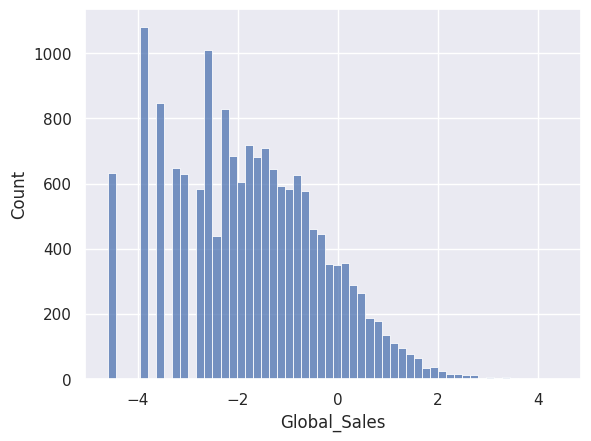

In [78]:
sns.histplot(np.log(df['Global_Sales']))

# Reconhecimento X Sucesso

In [79]:
df_rec_suc = df_critic.copy()

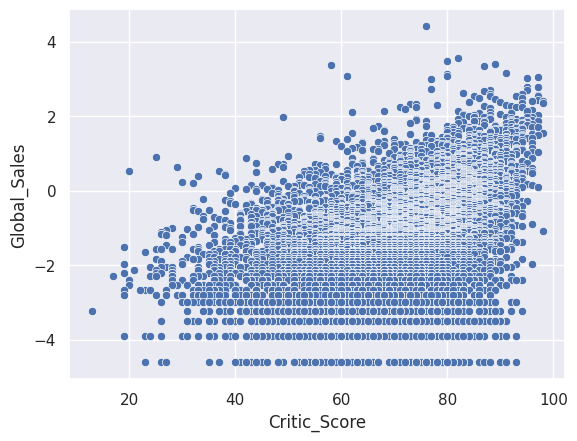

In [80]:
sns.scatterplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']));

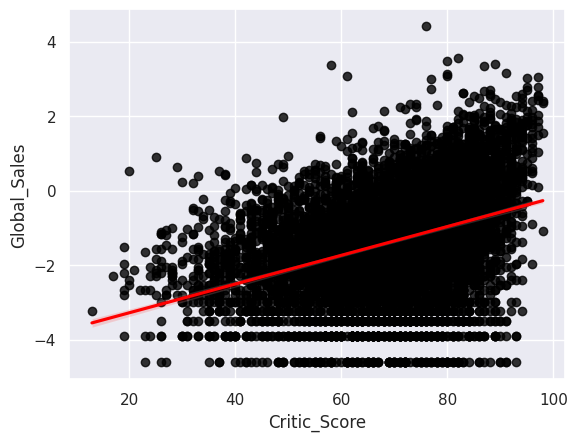

In [81]:
sns.regplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']), scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [82]:
result = reg.linear(data=df_rec_suc, formula='np.log(Global_Sales) ~ Critic_Score')

In [83]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.145
Model:                              OLS   Adj. R-squared:                  0.145
Method:                   Least Squares   F-statistic:                     1379.
Date:                  Mon, 21 Nov 2022   Prob (F-statistic):          6.57e-279
Time:                          14:17:34   Log-Likelihood:                -13712.
No. Observations:                  8133   AIC:                         2.743e+04
Df Residuals:                      8131   BIC:                         2.744e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.0526      0.073    -55.401      0.000      -4.196      -3.909
Critic_Score     0.0386      0.001     37.131      0.000       0.037       0.041
==============================================================================
Omnibus:                       46.420   Durbin-Watson:                   0.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.146
Skew:                          -0.186   Prob(JB):                     5.79e-11
Kurtosis:                       2.987   Cond. No.                         355.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
result.micro_summary()

variable,coefficient,std error,p-value
Critic_Score,0.038600,0.001040,0.000000


In [85]:
result.nano_summary()

+0.039 (0.001) ***


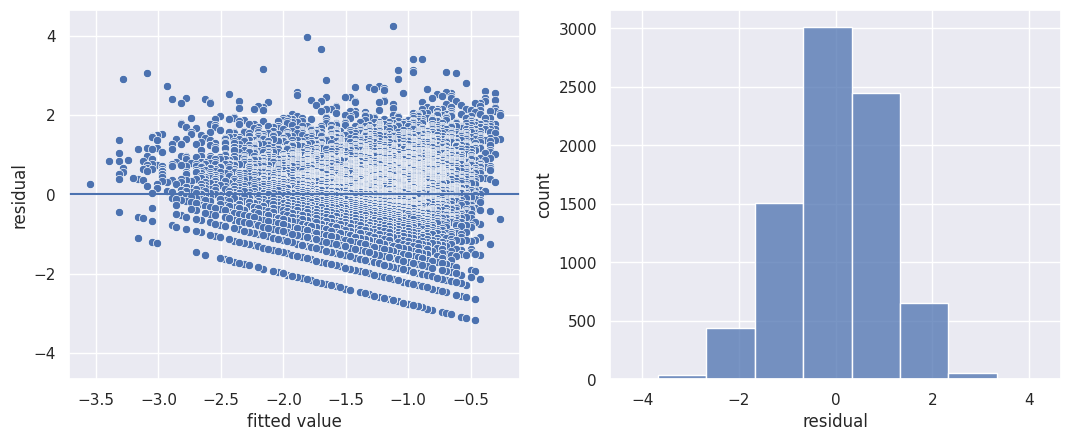

In [86]:
result.plot_residuals()

# Recepção X Sucesso

In [87]:
df_rep_suc = df_user.copy()

In [88]:
df_rep_suc.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


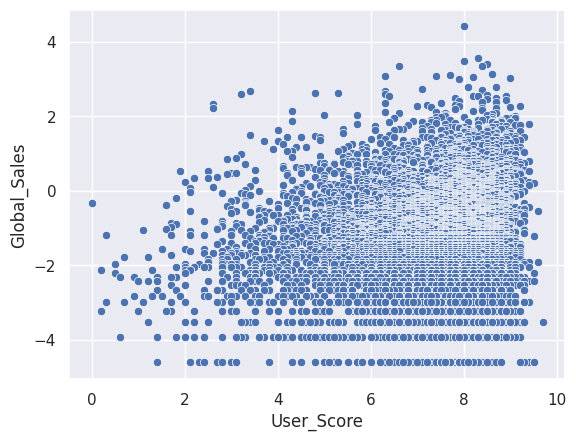

In [89]:
sns.scatterplot(x=df_rep_suc['User_Score'], y=np.log(df_rep_suc['Global_Sales']));

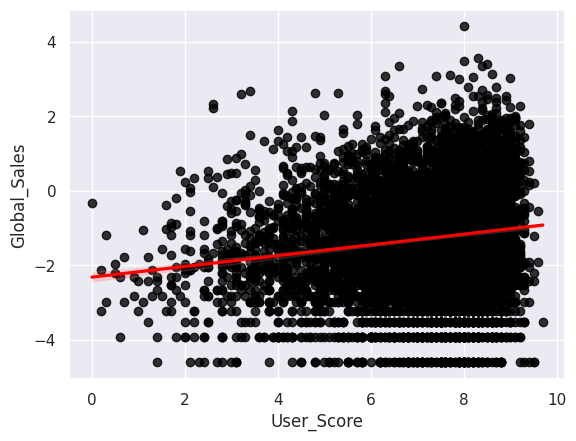

In [90]:
sns.regplot(x=df_rep_suc['User_Score'], y=np.log(df_rep_suc['Global_Sales']), scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [91]:
result = reg.linear(data=df_rep_suc, formula='np.log(Global_Sales) ~ User_Score')

In [92]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.024
Model:                              OLS   Adj. R-squared:                  0.023
Method:                   Least Squares   F-statistic:                     182.9
Date:                  Mon, 21 Nov 2022   Prob (F-statistic):           3.36e-41
Time:                          14:17:35   Log-Likelihood:                -13269.
No. Observations:                  7584   AIC:                         2.654e+04
Df Residuals:                      7582   BIC:                         2.656e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3157      0.078    -29.821      0.000      -2.468      -2.163
User_Score     0.1442      0.011     13.524      0.000       0.123       0.165
==============================================================================
Omnibus:                        5.061   Durbin-Watson:                   0.047
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                4.811
Skew:                          -0.032   Prob(JB):                       0.0902
Kurtosis:                       2.895   Cond. No.                         36.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
result.micro_summary()

variable,coefficient,std error,p-value
User_Score,0.144221,0.010664,0.000000


In [94]:
result.nano_summary()

+0.144 (0.011) ***


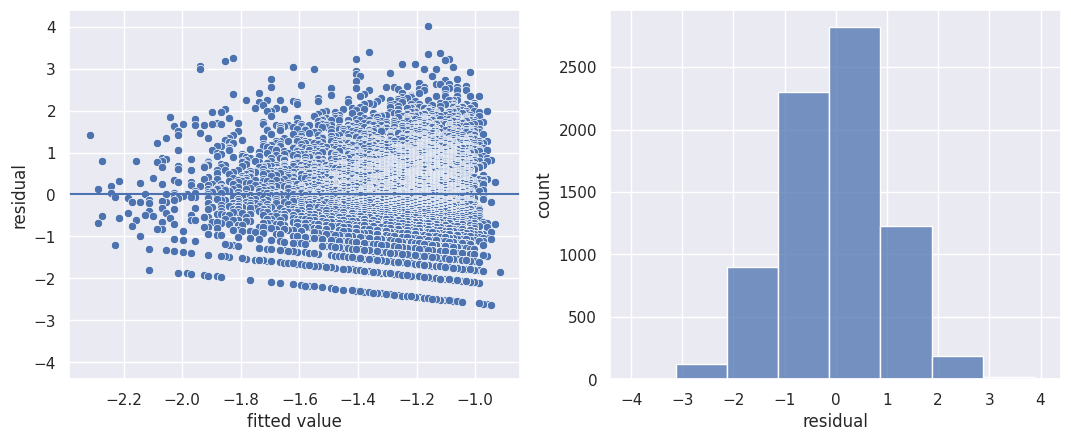

In [95]:
result.plot_residuals()

# Proximidade X Sucesso

In [96]:
df_pro_suc = df.copy()

In [97]:
g = gt_load("project_graph_closeness_component.net.gz")

In [98]:
data = gt_data(g)
data.drop('Games_released', axis=1, inplace=True)
data

,Publisher,closeness
id,,
Nintendo,Nintendo,0.675904
Microsoft Game Studios,Microsoft Game Studios,0.620575
Take-Two Interactive,Take-Two Interactive,0.879310
Sony Computer Entertainment,Sony Computer Entertainment,0.745020
Activision,Activision,0.933444
...,...,...
Commseed,Commseed,0.568966
UIG Entertainment,UIG Entertainment,0.534286
Takuyo,Takuyo,0.542029


In [99]:
df_pro_suc = pd.merge(df_pro_suc, data, on = "Publisher", how = "inner")
df_pro_suc.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,closeness
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E,0.675904
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,0.675904
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,0.675904
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E,0.675904
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,0.675904


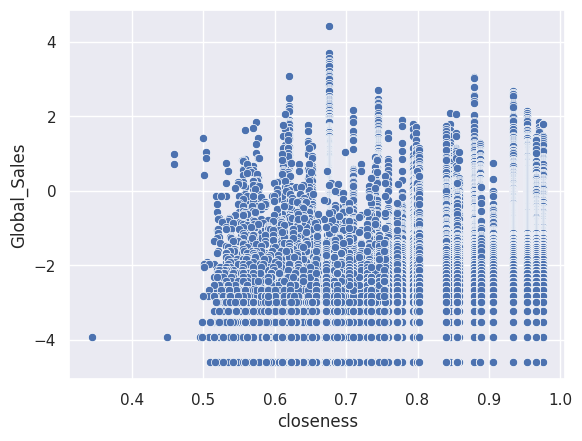

In [100]:
sns.scatterplot(x=df_pro_suc['closeness'], y=np.log(df_pro_suc['Global_Sales']));

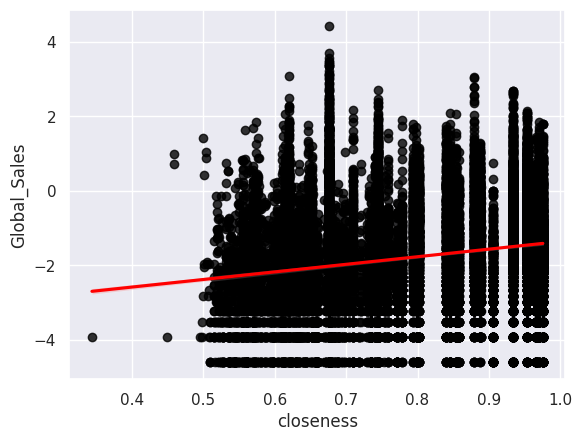

In [101]:
sns.regplot(x=df_pro_suc['closeness'], y=np.log(df_pro_suc['Global_Sales']), scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [102]:
result = reg.linear(data=df_pro_suc, formula='np.log(Global_Sales) ~ closeness')

In [103]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.036
Model:                              OLS   Adj. R-squared:                  0.036
Method:                   Least Squares   F-statistic:                     617.3
Date:                  Mon, 21 Nov 2022   Prob (F-statistic):          8.01e-134
Time:                          14:17:38   Log-Likelihood:                -29631.
No. Observations:                 16625   AIC:                         5.927e+04
Df Residuals:                     16623   BIC:                         5.928e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3958      0.067    -50.687      0.000      -3.527      -3.264
closeness      2.0356      0.082     24.845      0.000       1.875       2.196
==============================================================================
Omnibus:                      211.471   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.877
Skew:                           0.275   Prob(JB):                     4.88e-48
Kurtosis:                       2.889   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
result.micro_summary()

variable,coefficient,std error,p-value
closeness,2.035587,0.081932,0.000000


In [105]:
result.nano_summary()

+2.036 (0.082) ***


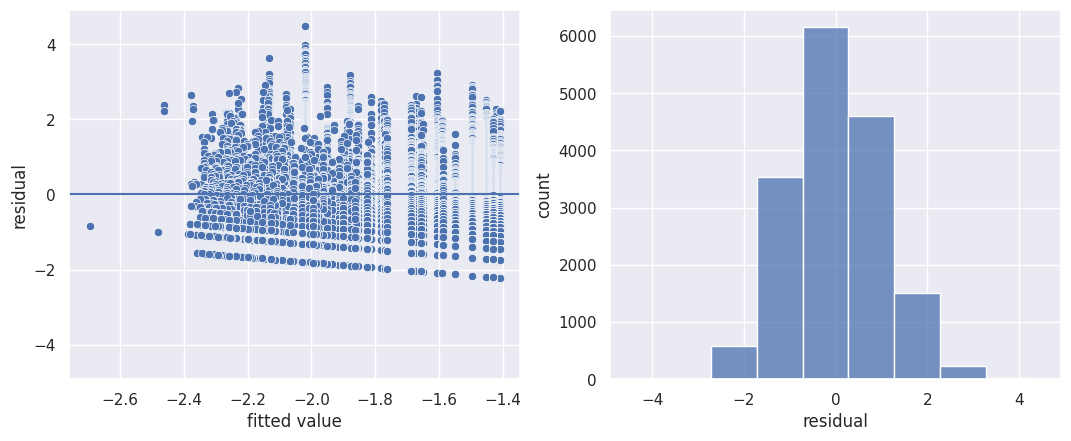

In [106]:
result.plot_residuals()

# Classificação etária X Sucesso

In [123]:
df_rat_suc = df_rating.copy()
df_rat_suc.loc[df_rat_suc['Rating'] == 'EC', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'E', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'E10+', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'K-A', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'M', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'T', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'AO', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'RP', 'Rating'] = 0
#df_rat_suc['Rating'] = df_rat_suc['Rating'].apply(pd.to_numeric)
df_rat_suc['Rating']

0        1
2        1
3        1
6        1
7        1
        ..
16701    1
16702    1
16706    1
16708    1
16710    0
Name: Rating, Length: 9943, dtype: object

/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 85.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 88.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


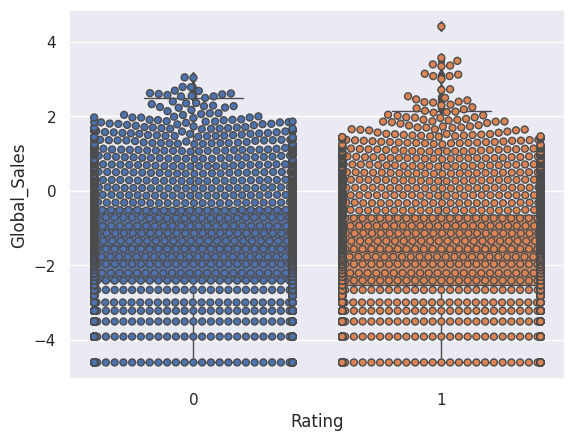

In [124]:
sns.boxplot(x=df_rat_suc['Rating'], y=np.log(df_rat_suc['Global_Sales']), linewidth=1)
sns.swarmplot(x=df_rat_suc['Rating'], y=np.log(df_rat_suc['Global_Sales']), linewidth=1);

In [125]:
result = reg.linear(data=df_rat_suc, formula='np.log(Global_Sales) ~ Rating')

In [126]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.003
Model:                              OLS   Adj. R-squared:                  0.002
Method:                   Least Squares   F-statistic:                     25.13
Date:                  Mon, 21 Nov 2022   Prob (F-statistic):           5.45e-07
Time:                          14:20:24   Log-Likelihood:                -17467.
No. Observations:                  9943   AIC:                         3.494e+04
Df Residuals:                      9941   BIC:                         3.495e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.4412      0.021    -69.153      0.000      -1.482      -1.400
Rating[T.1]    -0.1415      0.028     -5.013      0.000      -0.197      -0.086
==============================================================================
Omnibus:                       39.147   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.945
Skew:                           0.121   Prob(JB):                     9.50e-09
Kurtosis:                       2.825   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
result.nano_summary()

-0.142 (0.028) ***


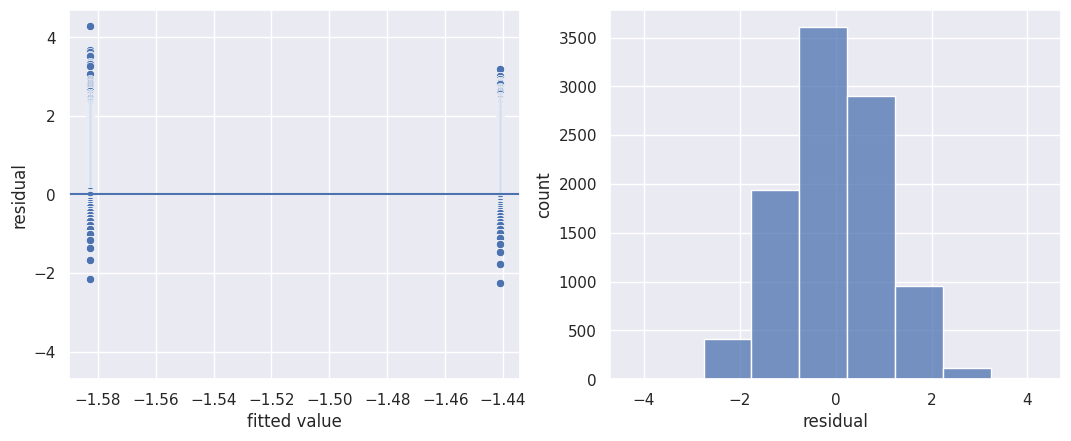

In [128]:
result.plot_residuals()

# Reconhecimento X Recepção

In [113]:
df_rec_rep = df.copy()

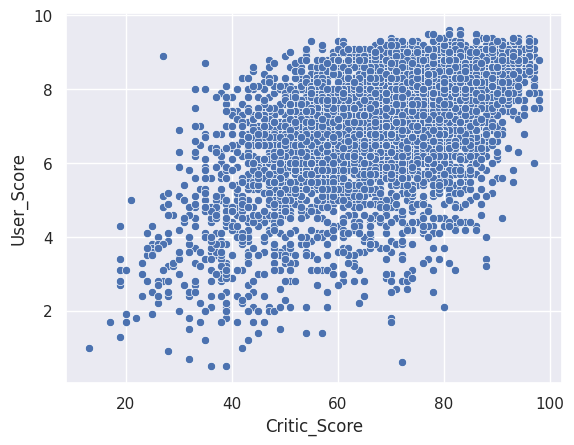

In [114]:
sns.scatterplot(x=df_rec_rep['Critic_Score'], y=df_rec_rep['User_Score']);

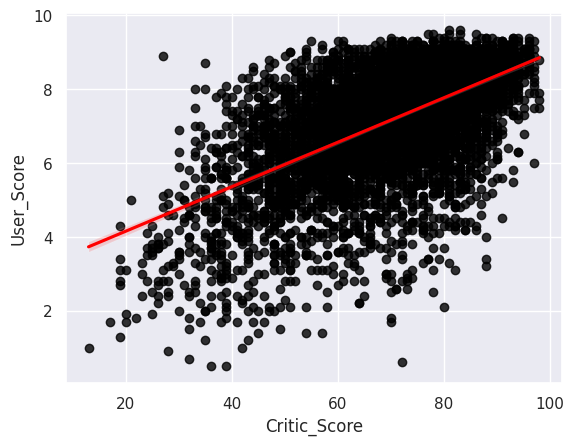

In [115]:
sns.regplot(x=df_rec_rep['Critic_Score'], y=df_rec_rep['User_Score'], scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [116]:
result = reg.linear(data=df_rec_rep, formula='User_Score ~ Critic_Score')

In [117]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             User_Score   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     3565.
Date:                Mon, 21 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:18:36   Log-Likelihood:                -11067.
No. Observations:                7013   AIC:                         2.214e+04
Df Residuals:                    7011   BIC:                         2.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.9496      0.072     40.809      0.000       2.808       3.091
Critic_Score     0.0603      0.001     59.705      0.000       0.058       0.062
==============================================================================
Omnibus:                     1031.378   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1923.539
Skew:                          -0.933   Prob(JB):                         0.00
Kurtosis:                       4.762   Cond. No.                         370.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
result.nano_summary()

+0.060 (0.001) ***


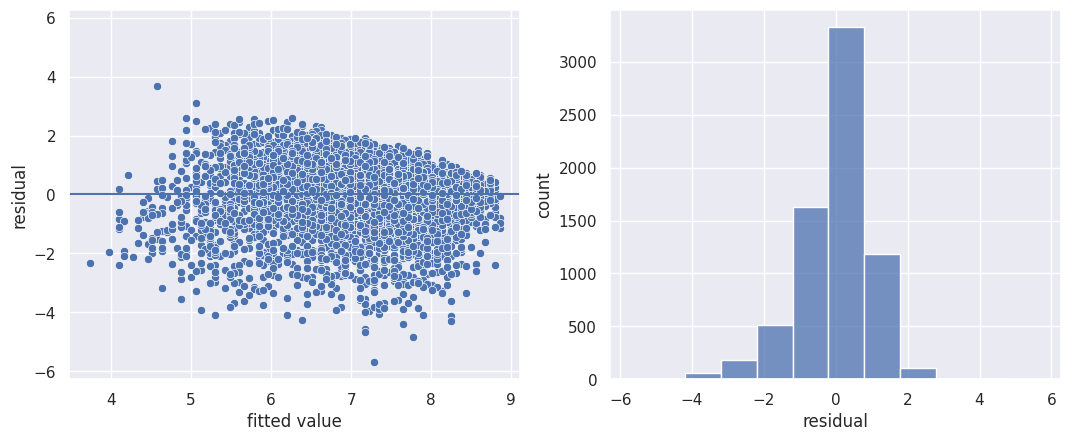

In [119]:
result.plot_residuals()

# Tudo junto X Sucesso

In [120]:
g = gt_load("project_graph_closeness_component.net.gz")

In [121]:
data = gt_data(g)
data.drop('Games_released', axis=1, inplace=True)
data

,Publisher,closeness
id,,
Nintendo,Nintendo,0.675904
Microsoft Game Studios,Microsoft Game Studios,0.620575
Take-Two Interactive,Take-Two Interactive,0.879310
Sony Computer Entertainment,Sony Computer Entertainment,0.745020
Activision,Activision,0.933444
...,...,...
Commseed,Commseed,0.568966
UIG Entertainment,UIG Entertainment,0.534286
Takuyo,Takuyo,0.542029


In [129]:
df_tud_suc = df.copy()
df_tud_suc.loc[df_tud_suc['Rating'] == 'EC', 'Rating'] = 1
df_tud_suc.loc[df_tud_suc['Rating'] == 'E', 'Rating'] = 1
df_tud_suc.loc[df_tud_suc['Rating'] == 'E10+', 'Rating'] = 1
df_tud_suc.loc[df_tud_suc['Rating'] == 'K-A', 'Rating'] = 1
df_tud_suc.loc[df_tud_suc['Rating'] == 'M', 'Rating'] = 0
df_tud_suc.loc[df_tud_suc['Rating'] == 'T', 'Rating'] = 0
df_tud_suc.loc[df_tud_suc['Rating'] == 'AO', 'Rating'] = 0
df_tud_suc.loc[df_tud_suc['Rating'] == 'RP', 'Rating'] = 0
df_tud_suc['Rating'] = df_tud_suc['Rating'].apply(pd.to_numeric)
df_tud_suc = pd.merge(df_tud_suc, data, on = "Publisher", how = "inner")
df_tud_suc.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,closeness
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,1.0,0.675904
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,0.675904
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,1.0,0.675904
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,1.0,0.675904
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,0.675904


In [130]:
result = reg.linear(data=df_tud_suc, formula='np.log(Global_Sales) ~ User_Score + Critic_Score + closeness + Rating')

In [131]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.149
Model:                              OLS   Adj. R-squared:                  0.148
Method:                   Least Squares   F-statistic:                     302.9
Date:                  Mon, 21 Nov 2022   Prob (F-statistic):          1.77e-240
Time:                          14:20:24   Log-Likelihood:                -11616.
No. Observations:                  6943   AIC:                         2.324e+04
Df Residuals:                      6938   BIC:                         2.328e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.6036      0.136    -33.778      0.000      -4.871      -4.336
User_Score      -0.0599      0.013     -4.508      0.000      -0.086      -0.034
Critic_Score     0.0394      0.001     28.509      0.000       0.037       0.042
closeness        1.1699      0.127      9.225      0.000       0.921       1.419
Rating           0.1287      0.031      4.122      0.000       0.068       0.190
==============================================================================
Omnibus:                       49.118   Durbin-Watson:                   0.408
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.177
Skew:                          -0.199   Prob(JB):                     1.27e-11
Kurtosis:                       3.120   Cond. No.                         810.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
result.nano_summary()

-0.060 (0.013) ***
+0.039 (0.001) ***
+1.170 (0.127) ***
+0.129 (0.031) ***


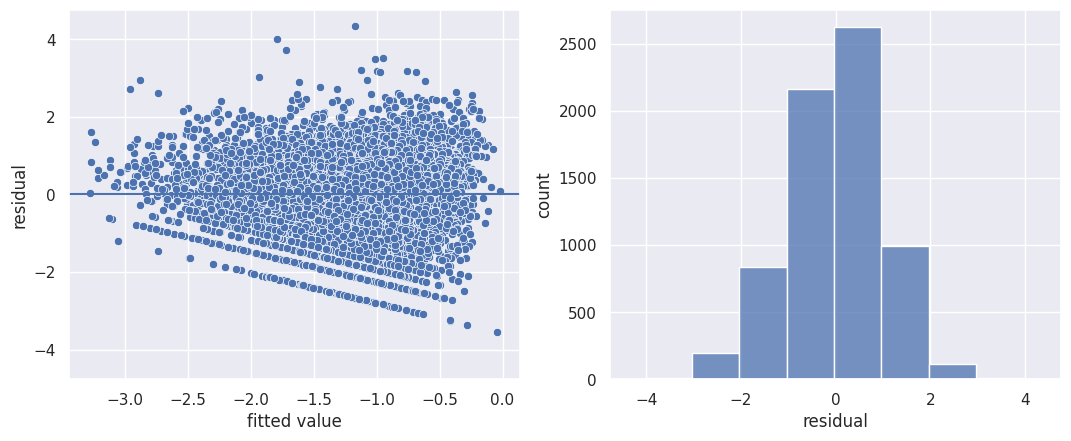

In [133]:
result.plot_residuals()